# Tutorial for Installation of the SI-Graph Repository 
# \& Replication of Simulations

## Installing Git Repo & Virtual Environment

The following tutorials requires a command line interface, e.g. Terminal on MacOS.
While the code should work in general for all python versions, python >= 3.10 is preferred.

Install [homebrew](https://brew.sh/)
1. Homebrew is required for installation of `pipx`. This requires a `sudo` command, but oftentimes on UM-affiliated computing clusters, this is not allowed for individual users. However, this step is optional as `pipx` can be safely replaced by `pip`.

If you were able to install homebrew, then install `pipx`:
1. brew install `pipx`
2. ```pipx ensurepath```
3. open new terminal (so that path changes take effect)

Use `pipx` to install virtualenv: `pipx install virtualenv`
1. Alternatively, if installation of pipx failed / is not authorized on your computer or on Great Lakes, it turns out replacing `pipx` with vanilla `pip` also works. (For Great Lakes usage, one may install on their home directory by specifying the installation with `--user`)
2. To install with `pip` on a cluster on which you don't have global installation authorization, install on your home directory using
```pip install <package> --user```
Replace `<package>` with the name of the package to be installed, e.g. `virtualenv`, `numpy`, ...

Clone the repository pertaining to your project from git:
1. Go to the repo: [SI for Gaussian Graphs](https://github.com/snigdhagit/SI-Graphs)
2. Click on `Code`
3. Copy the https link, for the above project it would be: "https://github.com/snigdhagit/SI-Graphs.git"
4. Go to terminal and type 
```git clone https://github.com/snigdhagit/SI-Graphs.git```

cd into `selective-inference` repo

Init and populate submodules: `git submodule update --init`

Create a new python3 virtual environment: e.g., `virtualenv env3 -p python3.10`
or in general `virtualenv env3 -p python3`

Active the environment: `source env3/bin/activate`

pip will likely fail to install `regreg` from `pypi` (where it looks for packages by default) because it's missing some wheels and doesn't have a source package there). Instead, install it from git
1. ```pip install git+https://github.com/regreg/regreg.git```
2. It will look like it fail but probably didn't: it tries to build a wheel for regreg which fails, it then falls back on setup.py install but there's a deprecation warning that starting with pip 21 it won't fall back anymore.

Use pip to install the rest. 
1. "requirements.txt" is a file that contains a list of package names to be installed in one-shot. It turns out sometimes this list is not comprehensive enough for some test/simulation files. Please install additional packages as needed if you have trouble running certain codes.
2. Again, on a cluster, you may need the `--user` option whenever pip is used.

## Replicate Simulations 

### Toy Example
Below we provide codes to replicate a few iterations for the simulation in Figure 1 of the paper.

In [2]:
import sys
import numpy as np
import pandas as pd
import random
import nose.tools as nt
import collections
collections.Callable = collections.abc.Callable

from matplotlib import pyplot as plt
import seaborn as sns

from selectinf.nbd_lasso import nbd_lasso
from selectinf.Utils.discrete_family import discrete_family
from selectinf.Tests.instance import GGM_instance
from selectinf.Tests.nbd_simulation import approx_inference_sim

from selectinf.Tests.nbd_naive_and_ds import *

In [6]:
def nbd_simulations_vary_weights(m=2, proportion=0.67, logic_tf=0,
                                 range_=range(0, 100), ncores=4,
                                 parallel=False):
    # Encoding binary logic into str
    if logic_tf == 0:
        logic = 'OR'
    elif logic_tf == 1:
        logic = 'AND'

    # Operating characteristics
    oper_char = {}
    oper_char["weight const"] = []
    oper_char["coverage rate"] = []
    oper_char["avg length"] = []
    oper_char["method"] = []
    oper_char["F1 score"] = []
    oper_char["F1 score (post inf)"] = []
    oper_char["E size"] = []
    # oper_char["Selection power"] = []
    oper_char["Cond. power"] = []
    # oper_char["Power post inf"] = []
    oper_char["FDP"] = []

    weights = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

    for weights_const in weights:
        n = 200#np_pair[0]
        p = 10#np_pair[1]
        ## print(n, p)
        #weights_const = 0.2
        ridge_const = 1.
        randomizer_scale = 1.
        ncoarse = 200

        for i in range(range_.start, range_.stop):
            n_instance = 0
            print(i)

            while True:  # run until we get some selection
                n_instance = n_instance + 1
                prec,cov,X = GGM_instance(n=n, p=p, max_edges=m, signal=0.4)
                n, p = X.shape
                # print((np.abs(prec) > 1e-5))
                noselection = False  # flag for a certain method having an empty selected set

                nonzero_n = naive_inference(X, prec, weights_const=weights_const,
                                            true_nonzero=None, logic=logic,
                                            solve_only=True, continued=False, nonzero_cont=None)

                nonzero_ds, subset_select = data_splitting(X, prec, weights_const=weights_const, proportion=proportion,
                                                           logic=logic, solve_only=True, continued=False,
                                                           nonzero_cont=None, subset_cont=None)

                noselection = np.min((nonzero_n.sum(), nonzero_ds.sum())) == 0
                if not noselection:
                    nonzero_approx, instance_approx\
                        = approx_inference_sim(X, prec, weights_const=weights_const,
                                               ridge_const=ridge_const,
                                               randomizer_scale=randomizer_scale,
                                               parallel=False, logic=logic,
                                               solve_only=True, continued=False,
                                               nbd_instance_cont=None)

                    noselection = np.min((nonzero_n.sum(), nonzero_ds.sum(), nonzero_approx.sum())) == 0

                # Continue with simultaneously nonzero instance
                if not noselection:
                    print("|E^*|:", (prec != 0).sum())
                    # Naive inference
                    nonzero_n, intervals_n, cov_rate_n, avg_len_n\
                        = naive_inference(X, prec,
                                          weights_const=weights_const,
                                          true_nonzero=None, logic=logic,
                                          solve_only=False, continued=True,
                                          nonzero_cont=nonzero_n)
                    print("Naive |E|:", nonzero_n.sum())

                    # Data splitting
                    nonzero_ds, intervals_ds, cov_rate_ds, avg_len_ds\
                        = data_splitting(X, prec,
                                         weights_const=weights_const,
                                         proportion=proportion,
                                         logic=logic, solve_only=False,
                                         continued=True,
                                         nonzero_cont=nonzero_ds,
                                         subset_cont=subset_select)
                    print("Data Splitting |E|:", nonzero_ds.sum())

                    # Approximate inference
                    nonzero_approx, intervals_approx, cov_rate_approx, avg_len_approx \
                        = approx_inference_sim(X, prec, weights_const=weights_const,
                                               ridge_const=ridge_const, randomizer_scale=randomizer_scale,
                                               parallel=parallel, ncores=ncores,
                                               logic=logic, solve_only=False, continued=True,
                                               nbd_instance_cont=instance_approx, ncoarse=ncoarse)
                    print("Approx |E|:", nonzero_approx.sum())

                if not noselection:
                    # F1 scores
                    # Post-inference selection
                    nonzero_n_int = interval_selection(intervals_n, nonzero_n)
                    nonzero_ds_int = interval_selection(intervals_ds, nonzero_ds)
                    nonzero_approx_int = interval_selection(intervals_approx, nonzero_approx)

                    # Selection F1-score
                    F1_n = calculate_F1_score_graph(prec, selection=nonzero_n)
                    F1_ds = calculate_F1_score_graph(prec, selection=nonzero_ds)
                    F1_approx = calculate_F1_score_graph(prec, selection=nonzero_approx)

                    # Post-inference F1-score
                    F1_pi_n = calculate_F1_score_graph(prec, selection=nonzero_n_int)
                    F1_pi_ds = calculate_F1_score_graph(prec, selection=nonzero_ds_int)
                    F1_pi_approx = calculate_F1_score_graph(prec, selection=nonzero_approx_int)


                    # Conditional Power post inference
                    cond_power_n = calculate_cond_power_graph(prec, selection=nonzero_n,
                                                             selection_CI=nonzero_n_int)
                    cond_power_ds = calculate_cond_power_graph(prec,
                                                               selection=nonzero_ds,
                                                             selection_CI=nonzero_ds_int)
                    cond_power_approx = calculate_cond_power_graph(prec,
                                                                selection=nonzero_approx,
                                                        selection_CI=nonzero_approx_int)

                    # FDP post inference
                    FDP_n = calculate_FDP_graph(beta_true=prec, selection=nonzero_n_int)
                    FDP_ds = calculate_FDP_graph(beta_true=prec,selection=nonzero_ds_int)
                    FDP_approx = calculate_FDP_graph(beta_true=prec,selection=nonzero_approx_int)


                    # Data splitting coverage
                    #oper_char["n,p"].append("(" + str(n) + "," + str(p) + ")")
                    oper_char["E size"].append(nonzero_ds.sum())
                    oper_char["coverage rate"].append(np.mean(cov_rate_ds))
                    oper_char["avg length"].append(np.mean(avg_len_ds))
                    oper_char["F1 score"].append(F1_ds)
                    oper_char["F1 score (post inf)"].append(F1_pi_ds)
                    oper_char["method"].append('Data Splitting')
                    oper_char["Cond. power"].append(cond_power_n)
                    oper_char["FDP"].append(FDP_n)
                    oper_char["weight const"].append(weights_const)

                    # Naive coverage
                    #oper_char["n,p"].append("(" + str(n) + "," + str(p) + ")")
                    oper_char["E size"].append(nonzero_n.sum())
                    oper_char["coverage rate"].append(np.mean(cov_rate_n))
                    oper_char["avg length"].append(np.mean(avg_len_n))
                    oper_char["F1 score"].append(F1_n)
                    oper_char["F1 score (post inf)"].append(F1_pi_n)
                    oper_char["method"].append('Naive')
                    oper_char["Cond. power"].append(cond_power_ds)
                    oper_char["FDP"].append(FDP_ds)
                    oper_char["weight const"].append(weights_const)

                    # Approximate Inference coverage
                    #oper_char["n,p"].append("(" + str(n) + "," + str(p) + ")")
                    oper_char["E size"].append(nonzero_approx.sum())
                    oper_char["coverage rate"].append(np.mean(cov_rate_approx))
                    oper_char["avg length"].append(np.mean(avg_len_approx))
                    oper_char["F1 score"].append(F1_approx)
                    oper_char["F1 score (post inf)"].append(F1_pi_approx)
                    oper_char["method"].append('Approx')
                    oper_char["Cond. power"].append(cond_power_approx)
                    oper_char["FDP"].append(FDP_approx)
                    oper_char["weight const"].append(weights_const)

                    print("# Instances needed for a non-null selection:", n_instance)

                    oper_char_df = pd.DataFrame.from_dict(oper_char)

                    break  # Go to next iteration if we have some selection
                    
    return oper_char

In [18]:
oper_char = nbd_simulations_vary_weights(m=2, proportion=0.67, logic_tf=1,
                                         range_=range(0, 5), ncores=1,
                                         parallel=False)

0
E estimated
|E^*|: 20
Naive |E|: 16
Data Splitting |E|: 8
Inference for 1 , 3
Inference for 1 , 8
Inference for 2 , 8
Inference for 3 , 5
Inference for 4 , 6
Approx |E|: 10
# Instances needed for a non-null selection: 1
1
E estimated
|E^*|: 26
Naive |E|: 20
Data Splitting |E|: 14
Inference for 0 , 1
Inference for 2 , 8
Inference for 3 , 4
Inference for 3 , 5
Inference for 4 , 8
Inference for 5 , 9
Inference for 6 , 8
Approx |E|: 14
# Instances needed for a non-null selection: 1
2
E estimated
|E^*|: 18
Naive |E|: 10
Data Splitting |E|: 14
Inference for 0 , 2
Inference for 0 , 3
Inference for 0 , 9
Inference for 1 , 5
Inference for 3 , 7
Inference for 5 , 9
Approx |E|: 12
# Instances needed for a non-null selection: 1
3
E estimated
|E^*|: 14
Naive |E|: 10
Data Splitting |E|: 14
Inference for 2 , 8
Inference for 3 , 8
Inference for 3 , 9
Inference for 5 , 7
Approx |E|: 8
# Instances needed for a non-null selection: 1
4
E estimated
|E^*|: 26
Naive |E|: 22
Data Splitting |E|: 20
Inference

### Plotting Toy Example Results

In [20]:
def point_plot(oper_char_df, x_axis='p', hue='method', plot_len=True,
               plot_ratio=False):
    def calculate_ratio(oper_char, proposed_name="Proposed"):
        oper_char = oper_char.copy()
        oper_char['simulation_id'] = oper_char.index // 3
        # Reshaping the DataFrame to have one row per simulation with A, B, and C as columns
        reshaped_df = oper_char.pivot(index="simulation_id", 
                                       columns='method',
                                       values='avg length')
        # Calculating the ratio of 'length' between A and C
        reshaped_df['length_ratio'] = reshaped_df[proposed_name] / reshaped_df['Data Splitting']
        
        # Extract the 'weight' column, since it's the same for each simulation you can simply drop duplicates
        weight_df = oper_char[['simulation_id', 'weight const']].drop_duplicates()
    
        # Merge the two dataframes on 'simulation_id'
        result_df = reshaped_df.merge(weight_df, on='simulation_id')
        
        return result_df
    
    oper_char_df = oper_char_df.copy()
    sns.set_style("white", {'axes.facecolor': 'white', 
                            'axes.grid': True,
                            'axes.linewidth': 2.0,
                            'grid.linestyle': u'--',
                            'grid.linewidth': 4.0,
                            'xtick.major.size': 5.0,
                           })
    #sns.histplot(oper_char_df["sparsity size"])
    #plt.show()
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    
    if "method" in oper_char_df.columns:
    
        alias = {"Approx":"Proposed", 
                 "Naive":"Naive", 
                 "Data Splitting":"Data Splitting"}
        #order = [alias[meth] for meth in order]
        
        oper_char_df['method'] = oper_char_df['method'].map(alias)
        
        my_palette = {"Proposed": "#48c072", 
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}
    
    print("Mean coverage rate/length:")
    print(oper_char_df.groupby([x_axis, hue]).mean())

    cov_plot = sns.pointplot(y=oper_char_df["coverage rate"],
                           x=oper_char_df[x_axis],
                           hue=oper_char_df[hue],
                           #hue_order=order, 
                           markers='o',
                           ax=ax1)
    
    #cov_plot.set(title='')
    """cov_plot.set_ylim(0., 1.05)
    #plt.tight_layout()
    cov_plot.axhline(y=0.9, color='k', linestyle='--', linewidth=1)"""
    ax1.set_ylabel("Coverage Rate", fontsize=15)  # remove y label, but keep ticks
    ax1.set_xlabel("Values of $\lambda$", fontsize=15)
    cov_plot.set_ylim(0., 1.05)
    #plt.tight_layout()
    cov_plot.axhline(y=0.9, color='k', linestyle='--', linewidth=1)
    
    if plot_len:
        len_plot = sns.pointplot(y=oper_char_df["avg length"],
                               x=oper_char_df[x_axis],
                               hue=oper_char_df[hue],
                               markers='o',
                               ax=ax2)
        #len_plot.set(title='Length')
        # len_plot.set_ylim(0, 100)
        # len_plot.set_ylim(3.5, 7.8)
        # plt.tight_layout()
        ax2.set_ylabel("Average Length", fontsize=15)  # remove y label, but keep ticks
        ax2.set_xlabel("Values of $\lambda$", fontsize=15)
        len_plot.set_ylim(0., 0.5)
    elif plot_ratio:
        ratio_df = calculate_ratio(oper_char_df)
        ratio_plot = sns.pointplot(y=ratio_df["length_ratio"],
                                   x=ratio_df["weight const"],
                                   markers='o',
                                   color="k")
        #len_plot.set(title='Length')
        # len_plot.set_ylim(0, 100)
        # len_plot.set_ylim(3.5, 7.8)
        # plt.tight_layout()
        ax2.set_ylabel("Average Length Ratio", fontsize=15) 
        ax2.set_xlabel("Values of $\lambda$", fontsize=15)
        ratio_plot.set_ylim(0, 1.0)

    handles, labels = ax1.get_legend_handles_labels()
    # fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.2)
    
    ax1.tick_params(axis='x', labelsize=15)
    ax1.tick_params(axis='y', labelsize=15)
    ax2.tick_params(axis='x', labelsize=15)
    ax2.tick_params(axis='y', labelsize=15)
    
    fig.subplots_adjust(bottom=0.26)
    fig.legend(handles, labels, loc='lower center', ncol=4, prop={'size': 15})

    cov_plot.legend_.remove()
    if plot_len:
        len_plot.legend_.remove()

    #plt.suptitle("Changing n,p")
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()

Mean coverage rate/length:
                             coverage rate  avg length  F1 score   
weight const method                                                
0.20         Data Splitting       0.971429    0.446701  0.245253  \
             Naive                0.578182    0.241840  0.314003   
             Proposed             0.913636    0.326740  0.284211   
0.25         Data Splitting       0.933333    0.450971  0.311538   
             Naive                0.563333    0.247213  0.423621   
             Proposed             0.820000    0.329419  0.258547   
0.30         Data Splitting       0.883333    0.461661  0.213333   
             Naive                0.146667    0.253397  0.300202   
             Proposed             1.000000    0.329374  0.344444   
0.35         Data Splitting       1.000000    0.456678  0.270476   
             Naive                0.500000    0.244127  0.336364   
             Proposed             0.950000    0.327458  0.260808   
0.40         Data Spl

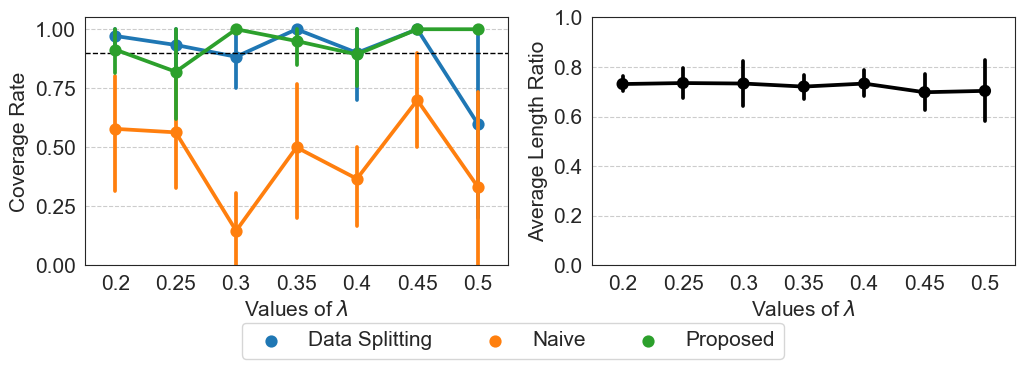

In [21]:
point_plot(pd.DataFrame(oper_char), x_axis="weight const", hue="method", plot_len=False,
           plot_ratio=True)

### Replicate the Simulation Section

To replicate the entire simulation selection, one can replace the function `nbd_simulations_vary_weights()` by one of the following:
1. `nbd_simulations_vary_signal()` to replicate Figure 2
2. `nbd_simulations_vary_signal_hub()` to replicate Figure 4
3. `nbd_simulations_vary_sparsity()` to replicate Figure 3
3. `nbd_simulations_vary_sparsity_hub()` to replicate Figure 5
The first two functions are under the path `selectinf/Tests/nbd_simulation_vary_signal.py`, while the last two functions are under `selectinf/Tests/nbd_simulation_vary_sparsity.py`.

While it is possible to replicate our simulations each with 500 repetitions on a JupyterNotebook, it is encouraged to submit the corresponding tasks to a computing cluster, configured per the instructions given previously. 

To submit corresponding jobs, one may use a sbatch file. An example is given below: